In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
print(os.getcwd())

C:\Users\rmcd\GitRepos\Python Projects\onhm-fetcher-parser\notebooks


# Open Gridmet max temperature with geopandas and plot

In [4]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1-2].shp")
# shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

C:\Users\rmcd\GitRepos\Python Projects\onhm-fetcher-parser\notebooks
..\Data
        POI_ID  hru_id_nat  hru_id_reg region  \
0      7733855           1           1     01   
1      7733919           2           2     01   
2      7732571           3           3     01   
3      7732387           4           4     01   
4      7733327           5           5     01   
5      7733755           6           6     01   
6      7732571           7           7     01   
7      7733923           8           8     01   
8      7733327           9           9     01   
9      7733755          10          10     01   
10     7734265          11          11     01   
11     7733789          12          12     01   
12     7734279          13          13     01   
13     7732571          14          14     01   
14     7732439          15          15     01   
15     7732355          16          16     01   
16     7732355          17          17     01   
17     7733789          18          18   

# Open Gridmet data (as netcdf file) print out some metadata
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [5]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
dirPath='http://thredds.northwestknowledge.net:8080'
fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'

#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath+fileName
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
datahandle=ds['air_temperature']
crshandle=ds['crs']
print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_2019.nc
<xarray.Dataset>
Dimensions:          (crs: 1, day: 105, lat: 585, lon: 1386)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 25.07 25.11 25.15 25.19 ... 49.32 49.36 49.4
  * day              (day) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-04-15
  * crs              (crs) int32 1
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatia

In [25]:
print(datahandle[dayshape-1, 480, 1232])

<xarray.DataArray 'air_temperature' ()>
array(nan)
Coordinates:
    lon      float64 -73.43
    lat      float64 45.07
    day      datetime64[ns] 2019-04-14
Attributes:
    units:         K
    description:   Daily Maximum Temperature
    grid_mapping:  crs
    cell_methods:  time: maximum(interval: 24 hours)
    height:        2 m


# Add netcdf data (tmax here) to dataframe that has hru id and geometry
* use weight file to assign tmax

In [26]:
def testnan(value, weight):
    if np.isnan(value): 
        tvalue = 0.0
        tweight = 0.0
    else:
        tvalue = value
        tweight = weight
    return tvalue, tweight
    

In [27]:
# print(len(data))
# print(data.shape)
# print(data)

# Test with Pandas groupby alternative to original method in following cell

106320 109943 106320 109951
   grid_ids  hru_id_nat         w
0     586.0       82896  0.351084
1     587.0       82896  0.915412
2     588.0       82896  1.000000
3     589.0       82896  1.000000
4     590.0       82896  1.000000
[nan nan nan ... nan nan nan]
109951 109951
<class 'numpy.float64'>


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Warning: converting a masked element to nan.


min/max -8.288538045651649 32.3057964509037


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


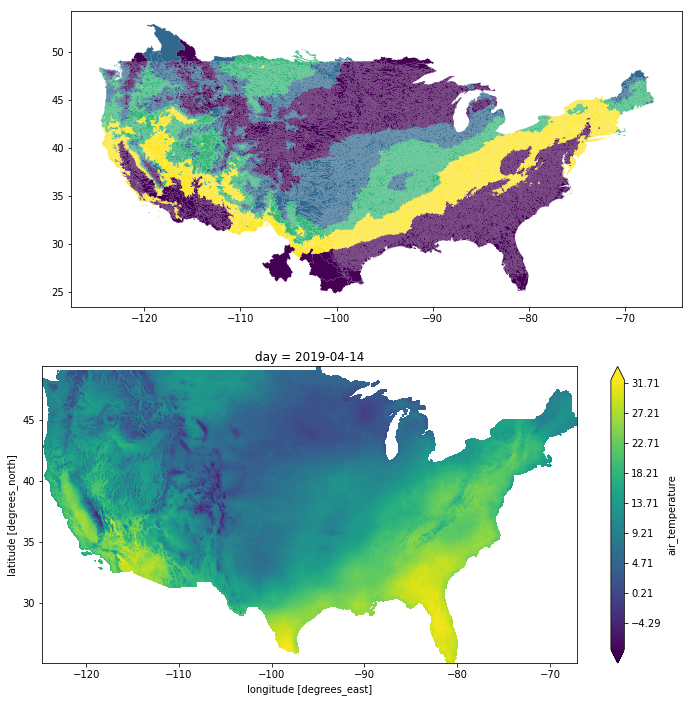

In [34]:
# add tmax column to dataframe
gdf['tmax']=0.0

#open weight data
wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), 
      len(wght_df_500['hru_id_nat'].unique()), len(wght_UofI['hru_id_nat'].unique()))
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')
# ndata=np.nan_to_num(data)
print(ndata[1000:])
# def w_mean(data)
unique_hru_ids = wght_UofI.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def get_wval(grp, ndata):
    ttmax = twght = 0.0
    for index, row in grp.iterrows():
        ttmax += row['w']*ndata[np.int(row['grid_ids'])]
        twght += row['w']
    return ttmax/twght
def np_get_wval(grp, ndata):
    return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
#     return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
    weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#     print(weight_id_rows['grid_ids'].values.astype(int))
#     unique_hru_ids.get_group(row['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})
#     gdf.loc[gdf.index[index],'tmax'] = np_get_wval(weight_id_rows, ndata)-273.5
    tmp = np_get_wval2(weight_id_rows, ndata)-273.5
    if index == 1:
        print(type(tmp))
    td[index] = np_get_wval2(weight_id_rows, ndata)-273.5
#     if td[index] < 0.0:
#         print(ndata[weight_id_rows['grid_ids'].values.astype(int)], weight_id_rows['w'])
#     print(index, td[index])
#     if row['hru_id_nat'] == 829:
#         print("in test")
#         for i2, el in weight_id_rows.iterrows():
#             print(el['w'], ndata[el['grid_ids'].astype(int)])
#         print(np.average(ndata[weight_id_rows['grid_ids'].values.astype(int)], weights=weight_id_rows['w'])-273.5)
#     print(index, row['hru_id_nat'], np_get_wval(weight_id_rows, ndata)-273.5)
#     gdf.loc[gdf.index[index], 'tmax'] =
# #     print(get_wval(weight_id_rows, ndata)-273.5)
# #     row.loc['tmax']=get_wval(weight_id_rows, ndata)-273.5
# #     gdf.loc[gdf.index[index], 'tmax'] = get_wval(weight_id_rows, ndata)-273.5
# print(len(td))
# gdf['tmax'] = gpd.GeoSeries([np.transpose(td)], index=gdf.index)
gdf['tmax'] = td.tolist()
gdf['tmax'].fillna(0.0)
# print(td.tolist())
print('min/max', gdf['tmax'].min(), gdf['tmax'].max())
# print(gdf)
# gdf.plot(figsize=(12,12), column = 'tmax',linewidth=0.25, edgecolor='white')    
# print(gdf.groupby(tmax).min)
f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white', scheme='quantiles')
ptmax = ds.air_temperature-273.5
ptmax_1 = ptmax.isel(day=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

In [ ]:
gdf

In [ ]:
# add tmax column to dataframe
gdf['tmax']=None

#open weight data
wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), len(wght_df_500['hru_id_nat'].unique()))
print(wght_df.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
unique_hru_ids = wght_UofI['hru_id_nat'].unique()
print(len(gdf), len(unique_hru_ids))
ndata=datahandle.values[dayshape-1,:,:].flatten(order='C')
for index, row in gdf.iterrows():
    weight_id_rows = wght_UofI.loc[wght_UofI['hru_id_nat'] == row['hru_id_nat']]
    ttmax = 0.0
    twght = 0.0
    tcount = 0
    # based on above metadata the shape of the netcdf file is day,lat(y),lon(x)
    for ind2, rw2 in weight_id_rows.iterrows():
#           print(rw2['Y_ind'],rw2['X_ind'])
#         tval, twt = testnan(datahandle.values[dayshape-1,int(rw2['Y_ind']),int(rw2['X_ind'])], rw2['w'])
        tval, twt = testnan(ndata[rw2['grid_ids'].astype(int)], rw2['w'])
        if twt > 0.0:
            ttmax += twt*tval
            twght += twt
            tcount += 1
#           if index == 4512: # test that discovered some weights associated with intesecting cells that are outside conus and return nan values
#               print(ind2, rw2['w'], ttmax, twght, tcount, datahandle.values[dayshape-1,int(rw2['Y_ind']),int(rw2['X_ind'])], rw2['Y_ind'], rw2['X_ind'])
    print(index, row['hru_id_nat'], tcount, ttmax, twght, ((ttmax/twght)-273.15))
    gdf.loc[gdf.index[index], 'tmax'] = ((ttmax/twght)-273.15)
#         data.setvalue(index, 'tmax', ((ttmax/twght)-273.15) * 9/5 + 32)
#         print('tmp', hru_id, row['tmax'])
# print(gdf)
# gdf.plot()
# f, ax = plt.subplots(2, figsize=(8,6))
# gdf.plot(ax=ax[0], column = 'tmax')
# ptmax = ds.air_temperature-273.5
# ptmax_1 = ptmax.isel(day=dayshape-1)
# ptmax_1.plot(ax=ax[1], levels=20)

# Convert netcdf to geotiff

In [ ]:
lat = lathandle.values
lon = lonhandle.values

transform = from_origin( lonmin, latmax, lonres, latres)
# res = (lon[-1] - lon[0])/lon.shape[0]
# print(res)
# transform2 = from_origin(lon[0]-res/2, lat[-1]+res/2, res, res) 
# print(transform, transform2)
new_dataset = rasterio.open(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif', 'w', driver='GTiff',
                            height = lonshape, width = latshape,
                            count=1, dtype=str(datahandle.dtype),
                            crs={'init': 'epsg:4326'},
                            transform=transform)
# vals = np.transpose(datahandle.values, [1,2,0])
# vals2 = vals[:,:,85-1]
vals = datahandle.values[dayshape-1, :, :]
print(vals.shape)
# im = np.transpose(vals, [1,2,0])
# fa = np.asfortranarray(vals)
# ca = np.asanyarray(vals, order='C')
ud = (np.flipud(vals)-273.15) * 9/5 + 32
# at = np.transpose(vals)
# atf = np.rot90(at)
new_dataset.write(ud, 1)
# new_dataset.warp.transform
# print(new_dataset.transform)
# pyplot.imshow(new_dataset.read(1), cmap='pink')
# pyplot.show()
print(new_dataset)
new_dataset.close()

# Plot geotiff raster data

In [ ]:
os.chdir(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip')
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)
print(src)
plt.imshow(array, interpolation='nearest')
plt.colorbar()
plt.title('max temp')
plt.show()
src.close()

# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

In [ ]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), prefix='tmax_', all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='tmax_mean', cmap='viridis')

# Alternative Rasterstats method: 
* https://geohackweek.github.io/vector/06-geopandas-advanced/

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

# print(transform)
with rasterio.open(r'test1.tif') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

In [ ]:
print(len(stats_gdf.index))

# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [ ]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')

# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(stats_gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = stats_gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = stats_gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = stats_gdf['tmax_mean'].values

print(ncfile)
ncfile.close(); print("dataset is closed")
